# Курсовая работа. Речицкий Данил Дмитриевич БВТ2203

In [ ]:
%pip install matplotlib
%pip install pandas
%pip install tabulate

# Моделирование расписаний, глобальные переменные

In [10]:
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import random
import pandas as pd
from tabulate import tabulate

WORKING_HOURS_START = 6
WORKING_HOURS_END = 23
PEAK_HOURS_MORNING = (7, 9)
PEAK_HOURS_EVENING = (17, 19)
ROUTE_STOPS = ["A", "B", "C", "D", "E"]
NUM_BUSES = 8
NUM_DAYS = 7

#для расписания остановок по дням недели
class StopSchedule:
    def __init__(self, stop_name):
        self.stop_name = stop_name
        self.schedule = {day: [] for day in range(NUM_DAYS)}

class Simulation:
    def __init__(self):
        self.stops = {stop: StopSchedule(stop) for stop in ROUTE_STOPS}
        self.bus_drivers = {f"bus{bus_id}": {"type": random.choice(["A", "B"]), "current_driver": 1} for bus_id in range(1, NUM_BUSES + 1)}
        self.driver_breaks = {f"bus{bus_id}": {day: [] for day in range(NUM_DAYS)} for bus_id in range(1, NUM_BUSES + 1)}#для остановок и перерывов
    #создание расписания на неделю
    def initialize_weekly_schedule(self):
        for day in range(NUM_DAYS):
            start_time = datetime.strptime(f"{WORKING_HOURS_START}:00", "%H:%M")#преобразуем время
            end_time = datetime.strptime(f"{WORKING_HOURS_END}:00", "%H:%M")
            #каждому автобусу присваиваем водителя + устанавливаем данные водителя
            for bus_id in range(1, NUM_BUSES + 1):
                bus_name = f"bus{bus_id}"
                driver_type = self.bus_drivers[bus_name]["type"]
                driver_shift_hours = 8 if driver_type == "A" else 12
                driver_breaks = [60] if driver_type == "A" else [30, 30]
                shift_duration = timedelta(hours=driver_shift_hours)
                break_durations = [timedelta(minutes=b) for b in driver_breaks]#преобразовываем массив в формат времени
                driver_end_time = start_time + shift_duration
                current_time = start_time + timedelta(minutes=random.randint(0, 30))#рандомное начало работы
                #здесь для каждого автобуса, проходимся по всем остановкам, пока не кончится время работы. таким образом составляя расписание их остановок
                while current_time < end_time:
                    for stop in ROUTE_STOPS:#проходимся по всем остановкам
                        #тут делаем перерыв на обэд 20% шанс, добавляем инфу в таблицу и делаем сдвиги текущ времени
                        if break_durations and random.random() < 0.2:
                            break_duration = break_durations.pop(0)
                            driver_name = f"{driver_type}{self.bus_drivers[bus_name]['current_driver']}"
                            self.driver_breaks[bus_name][day].append(
                                (driver_name, current_time.time(), (current_time + break_duration).time()))#в таблицу
                            current_time += break_duration
                        #пересменка водителей
                        if current_time + timedelta(minutes=12) > driver_end_time:
                            current_time += timedelta(minutes=15)#15 мин пересменка
                            self.bus_drivers[bus_name]["current_driver"] += 1
                            driver_type = random.choice(["A", "B"])
                            self.bus_drivers[bus_name]["type"] = driver_type
                            driver_shift_hours = 8 if driver_type == "A" else 12
                            driver_breaks = [60] if driver_type == "A" else [30, 30]
                            shift_duration = timedelta(hours=driver_shift_hours)
                            break_durations = [timedelta(minutes=b) for b in driver_breaks]
                            driver_end_time = current_time + shift_duration
                        arrival_time = current_time
                        driver_name = f"{driver_type}{self.bus_drivers[bus_name]['current_driver']}"
                        self.stops[stop].schedule[day].append((arrival_time.time(), bus_id, driver_name))
                        current_time += timedelta(minutes=12)
    #расписание остановок красиво
    def format_schedule_into_columns(self):
        days = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
        formatted_columns = {day: [] for day in days}
        for day_idx, day_name in enumerate(days):
            for stop, stop_schedule in self.stops.items():
                formatted_columns[day_name].append(f"{stop}:")
                sorted_times = sorted(stop_schedule.schedule[day_idx], key=lambda x: x[0])
                formatted_times = [f"{time} - Автобус {bus_id} (Водитель {driver})" for time, bus_id, driver in sorted_times]
                formatted_columns[day_name].extend(formatted_times)
                formatted_columns[day_name].append("")
        max_rows = max(len(column) for column in formatted_columns.values())
        for day in days:
            formatted_columns[day].extend([""] * (max_rows - len(formatted_columns[day])))

        return pd.DataFrame(formatted_columns)
    #расписание водителей красиво
    def format_driver_breaks_into_columns(self):
        days = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
        formatted_columns = {day: [] for day in days}
        for day_idx, day_name in enumerate(days):
            formatted_columns[day_name].append(f"День {day_name}:")
            for bus_name, daily_breaks in self.driver_breaks.items():
                formatted_columns[day_name].append(f"Автобус {bus_name[-1]}:")
                for driver_name, start, end in daily_breaks[day_idx]:
                    formatted_columns[day_name].append(f"  {driver_name} - Перерыв: {start} - {end}")
                formatted_columns[day_name].append("")
        max_rows = max(len(column) for column in formatted_columns.values())
        for day in days:
            formatted_columns[day].extend([""] * (max_rows - len(formatted_columns[day])))

        return pd.DataFrame(formatted_columns)

# Класс симуляции пассажиропотока

In [13]:
class IntegratedPassengerFlowSimulation:
    def __init__(self, stops, peak_hours, bus_capacity=50, day_factors=None):
        self.stops = stops#словарь остановок
        self.peak_hours = peak_hours
        self.bus_capacity = bus_capacity
        self.passenger_waiting = {stop: [] for stop in stops.keys()}#хранит время ожидания
        self.passengers_unable_to_board = {stop: [0] * NUM_DAYS for stop in stops.keys()}#кол-во ожидающих людей по остановкам
        self.total_waiting_time = [0] * NUM_DAYS  #список для хранения общего времени ожидания пассажиров для каждого дня.
        self.passenger_generation_rates = {"peak": 5,"off_peak": 2}#коэф. генерации людей в часы пик и вне пиков
        self.max_passengers_per_hour = 100 #ограничение пассажиров за час
        self.day_factors = day_factors if day_factors else [1.0] * NUM_DAYS#множитель дня
    #симуляция пассажиропотока
    def simulate_day(self, day, simulation_start_time=6, simulation_end_time=23):
        current_time = datetime.strptime(f"{simulation_start_time}:00", "%H:%M")
        end_time = datetime.strptime(f"{simulation_end_time}:00", "%H:%M")
        day_factor = self.day_factors[day]
        #словарь для отслеживания пассажиров на каждой остановке в течение часа
        hourly_generated_passengers = {stop: 0 for stop in self.stops.keys()}
        while current_time <= end_time:
            hour = current_time.hour#берем текущ. час
            #генерируем пассажиров в зависимости от час пика и дей фактора. В итоге это происходит в течение часа 60 раз. и там от 0 до 100 челов генерит за час
            for stop in self.stops.keys():
                rate = self.passenger_generation_rates["peak"] if self.is_peak_hour(hour) else self.passenger_generation_rates["off_peak"]
                new_passengers = int(random.randint(0, rate) * day_factor)
                if hourly_generated_passengers[stop] + new_passengers <= self.max_passengers_per_hour:
                    self.passenger_waiting[stop] += [current_time.time()] * new_passengers#создаем список с одинаковым временем.Повторяется кол-во пассажиров
                    hourly_generated_passengers[stop] += new_passengers#обновляем кол-во пассажиров

            for stop, schedule in self.stops.items():#получаем для остановки имя и расписание на день
                for arrival_time, bus_id, driver_name in schedule.schedule[day]:#schedule[day] — это список для дня, в котором данные о времени прибытия автобусов, их (bus_id) и (driver_name).
                    if arrival_time == current_time.time():#если текущее время совпадает с временем прибытия, то вызываем функцию
                        self.board_passengers(stop, current_time, day, bus_id)

            if current_time.minute == 59:#обнуляем кол-во пассажиров для каждой остановки
                hourly_generated_passengers = {stop: 0 for stop in self.stops.keys()}

            current_time += timedelta(minutes=1)#+1 минуты
        #в конце дня длину passenger_waiting прибавляем по дням и основкам, чтобы записать сколько человек не уехало
        for stop, passengers in self.passenger_waiting.items():
            remaining_passengers = len(passengers)
            if remaining_passengers > 0:
                self.passengers_unable_to_board[stop][day] += remaining_passengers
            self.passenger_waiting[stop] = []  #обнуляем список
    #чек на пиковый час или не
    def is_peak_hour(self, hour):
        return self.peak_hours["morning"][0] <= hour <= self.peak_hours["morning"][1] or \
               self.peak_hours["evening"][0] <= hour <= self.peak_hours["evening"][1]

    def board_passengers(self, stop, current_time, day, bus_id):#метод для посадки пассажиров
        if self.passenger_waiting[stop]:#не пуст ли список ожидающих на остановки
            passengers_boarded = min(len(self.passenger_waiting[stop]), self.bus_capacity)#выбираем кол-во людей, которых можем посадить
            waiting_passengers = self.passenger_waiting[stop][:passengers_boarded]#забираем первых пассажиров
            self.total_waiting_time[day] += sum([(current_time.minute - passenger.minute) % 60 for passenger in waiting_passengers])#для каждого пассажира,который сел вычисляется время ожидания и прибавляется к общему

            remaining = len(self.passenger_waiting[stop]) - passengers_boarded
            self.passengers_unable_to_board[stop][day] += remaining#считаем челов, которые не успели сесть и обновляем кол-во. По факту тут считается так, что если чел не сел на один автобус, он считается в стату
            self.passenger_waiting[stop] = self.passenger_waiting[stop][passengers_boarded:]#срезаем список,чтобы убрать севших

    def summarize_results(self):#вывод всех результатов симуляции
        print("\nСтатистика пассажиропотока по дня:")
        for stop, daily_counts in self.passengers_unable_to_board.items():
            print(f"Остановка {stop}:")
            for day, count in enumerate(daily_counts):
                print(f"  День {day + 1}: {count} пассажиров, которые не смогли уехать.")
        print("\nОбщее время ожидания пассажиров по дням:")
        for day, time in enumerate(self.total_waiting_time):
            print(f"  День {day + 1}: {time} минут.")
        total_waiting_time_7_days = sum(self.total_waiting_time)
        print(f"Общее время ожидания пассажиров за неделю: {total_waiting_time_7_days} минут.")
        return self.total_waiting_time

# Вывод расписания остановок и перерывов водителей

In [ ]:
def display_dataframe(name, dataframe):
    print(f"\n=== {name} ===\n")
    print(tabulate(dataframe, headers='keys', tablefmt='grid', showindex=False))

sim = Simulation()
sim.initialize_weekly_schedule()#создание расписания на неделю

df_columns_schedule = sim.format_schedule_into_columns()
display_dataframe(name="Расписание остановок", dataframe=df_columns_schedule)


=== Расписание остановок ===

+------------------------------------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+-------------------------------------+
| Понедельник                        | Вторник                            | Среда                              | Четверг                            | Пятница                            | Суббота                             | Воскресенье                         |
+====================================+====================================+====================================+====================================+====================================+=====================================+=====================================+
| A:                                 | A:                                 | A:                                 | A:                                 | A:                            

In [18]:
df_driver_breaks = sim.format_driver_breaks_into_columns()
display_dataframe(name="Расписание перерывов водителей", dataframe=df_driver_breaks)


=== Расписание перерывов водителей ===

+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+------------------------------------+------------------------------------+
| Понедельник                       | Вторник                           | Среда                             | Четверг                           | Пятница                           | Суббота                            | Воскресенье                        |
+===================================+===================================+===================================+===================================+===================================+====================================+====================================+
| День Понедельник:                 | День Вторник:                     | День Среда:                       | День Четверг:                     | День Пятница:                     | День Субб

In [4]:
#функция копирования изначального расписания
def copy_schedule(stops):
    new_schedule = {stop: StopSchedule(stop) for stop in stops.keys()}
    for stop_name, stop_schedule in stops.items():
        for day, trips in stop_schedule.schedule.items():
            new_schedule[stop_name].schedule[day] = trips.copy()
    return new_schedule

# Алгоритм "в лоб"

In [15]:
def brute_force_optimization(sim, iterations=100):
    print("\n=== Результаты брут-форс оптимизации ===")
    best_schedule = sim.stops#хранят лучшее расписание и score
    best_score = float("inf")

    for iteration in range(iterations):#запускаем цикл на  количество итераций
        temp_sim = Simulation()
        temp_sim.stops = copy_schedule(sim.stops)#копируем изначальное расписание
        #Проходимся в каждом дне по расписанию каждой остановки и меняем время
        for day in range(NUM_DAYS):
            for stop_name, stop_schedule in temp_sim.stops.items():
                for idx, (arrival_time, bus_id, driver) in enumerate(stop_schedule.schedule[day]):#проходит по расписанию контректной остновки
                    shift = random.choice([-15, 0, 15])
                    new_time = (datetime.combine(datetime.today(), arrival_time) + timedelta(minutes=shift)).time()
                    stop_schedule.schedule[day][idx] = (new_time, bus_id, driver)#изменяем расписание, сдвигая его на +-15 минут.

        #создаем новую симуляцию пассажиропотока
        temp_flow = IntegratedPassengerFlowSimulation(stops=temp_sim.stops, peak_hours={"morning": PEAK_HOURS_MORNING, "evening": PEAK_HOURS_EVENING}, bus_capacity=50)
        for day in range(NUM_DAYS):
            temp_flow.simulate_day(day)

        #оцениваем общее кол-во людей, не успевших сесть и общее кол-во времени. Далее считаем score по этим данным
        total_unable = sum(sum(counts) for counts in temp_flow.passengers_unable_to_board.values())
        total_waiting = sum(temp_flow.total_waiting_time)
        score = total_unable + total_waiting
        #и соответственно обновляем score, если он лучше
        if score < best_score:
            best_score = score
            best_schedule = temp_sim.stops

    #применяем лучшее расписание
    sim.stops = best_schedule
    #симуляция уже с оптимизированым расписанием
    optimized_sim = IntegratedPassengerFlowSimulation(stops=sim.stops,peak_hours={"morning": PEAK_HOURS_MORNING, "evening": PEAK_HOURS_EVENING},bus_capacity=50)
    for day in range(NUM_DAYS):
        optimized_sim.simulate_day(day)

    print("\nОптимизированые результаты:")
    optimized_sim.summarize_results()

    return optimized_sim.total_waiting_time#для построения графиков возврат общего времени ожидания

# Генетический алгоритм

In [11]:
def genetic(sim, population_size=5, gens=5):
    print("\n=== Результаты генетической оптимизации ===")
    mutation_pb = 0.1#мутация
    cross_pb = 0.6#кроссовер

    def init_individual():#создаем индивидов со сдвигами расписания
        return [random.choice([-15, 0, 15]) for _ in range(NUM_BUSES * NUM_DAYS)]

    def init_population(size):#создаем популяцию из индивидов
        return [init_individual() for _ in range(size)]

    #функция оценки приспособл. индивидуума(fitness)
    def evaluate_schedule(individual):
        temp_sim = Simulation()
        temp_sim.stops = copy_schedule(sim.stops)#копируем расписание
        #Проходимся в каждом дне по расписанию каждой остановки и применяем сдвиги времени
        for day in range(NUM_DAYS):
            for bus_id, shift in enumerate(individual[day * NUM_BUSES:(day + 1) * NUM_BUSES]):
                for stop in temp_sim.stops.values():
                    for idx, (arrival_time, bus, driver) in enumerate(stop.schedule[day]):
                        if bus == bus_id + 1:
                            new_time = (datetime.combine(datetime.today(), arrival_time) + timedelta(minutes=shift)).time()
                            stop.schedule[day][idx] = (new_time, bus, driver)

        #создаем временую симуляцию пассажиропотока
        temp_flow = IntegratedPassengerFlowSimulation(stops=temp_sim.stops,peak_hours={"morning": PEAK_HOURS_MORNING, "evening": PEAK_HOURS_EVENING},bus_capacity=50)
        for day in range(NUM_DAYS):
            temp_flow.simulate_day(day)
        #оцениваем его общий score
        total_unable = sum(sum(counts) for counts in temp_flow.passengers_unable_to_board.values())
        total_waiting = sum(temp_flow.total_waiting_time)
        return total_unable + total_waiting  # Меньше — лучше

    def crossover(parent1, parent2):#кроссовер.Выбираем точку по которое делятся родители и создаем по ней 2 новых индивидуума
        if random.random() < cross_pb:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return parent1, parent2

    def mutate(individual):#мутация. Если шанс прокает, меняем рандомный сдвиг времени на другой.
        if random.random() < mutation_pb:
            index = random.randint(0, len(individual) - 1)
            individual[index] = random.choice([-15, 0, 15])
        return individual

    #запуск генетического алгоритма
    population = init_population(population_size)
    for gen in range(gens):
        #каждого индивида оцениваем, сортируем и оставляем лучших
        fitness_scores = [(evaluate_schedule(ind), ind) for ind in population]#хранит значение приспособленности и индивидуума
        fitness_scores.sort(key=lambda x: x[0])
        selected = [ind for score, ind in fitness_scores[:population_size // 2]]#селекция.

        #кроссовер
        next_population = []
        while len(next_population) < population_size:
            parent1, parent2 = random.sample(selected, 2)
            child1, child2 = crossover(parent1, parent2)
            next_population.extend([child1, child2])

        #на каждый индивид mutate. И все измененные индивиды в population
        population = [mutate(ind) for ind in next_population]
    #делаем применение последнего поколения
    fitness_scores = [(evaluate_schedule(ind), ind) for ind in population]
    fitness_scores.sort(key=lambda x: x[0])
    #после всех поколений останется кортежи с лучшими особями. Из него выбираем с самым минимальным score и берем оттуда индвидуума
    best_individual = min(fitness_scores, key=lambda x: x[0])[1]

    #применяем к расписанию результаты
    for day in range(NUM_DAYS):
        for bus_id, shift in enumerate(best_individual[day * NUM_BUSES:(day + 1) * NUM_BUSES]):
            for stop in sim.stops.values():
                for idx, (arrival_time, bus, driver) in enumerate(stop.schedule[day]):
                    if bus == bus_id + 1:
                        new_time = (datetime.combine(datetime.today(), arrival_time) + timedelta(minutes=shift)).time()
                        stop.schedule[day][idx] = (new_time, bus, driver)

    #создаем симуляцию с оптимизированными данными и возвращаем результаты
    optimized_sim = IntegratedPassengerFlowSimulation(stops=sim.stops,peak_hours={"morning": PEAK_HOURS_MORNING, "evening": PEAK_HOURS_EVENING},bus_capacity=50)
    for day in range(NUM_DAYS):
        optimized_sim.simulate_day(day)

    print("\nОптимизированные результаты:")
    optimized_sim.summarize_results()

    return optimized_sim.total_waiting_time


# Вывод результатов. Сравнение графиков.


=== Изначальные результаты ===

Статистика пассажиропотока по дня:
Остановка A:
  День 1: 43 пассажиров, которые не смогли уехать.
  День 2: 26 пассажиров, которые не смогли уехать.
  День 3: 85 пассажиров, которые не смогли уехать.
  День 4: 150 пассажиров, которые не смогли уехать.
  День 5: 26 пассажиров, которые не смогли уехать.
  День 6: 51 пассажиров, которые не смогли уехать.
  День 7: 31 пассажиров, которые не смогли уехать.
Остановка B:
  День 1: 124 пассажиров, которые не смогли уехать.
  День 2: 51 пассажиров, которые не смогли уехать.
  День 3: 73 пассажиров, которые не смогли уехать.
  День 4: 148 пассажиров, которые не смогли уехать.
  День 5: 57 пассажиров, которые не смогли уехать.
  День 6: 83 пассажиров, которые не смогли уехать.
  День 7: 63 пассажиров, которые не смогли уехать.
Остановка C:
  День 1: 149 пассажиров, которые не смогли уехать.
  День 2: 61 пассажиров, которые не смогли уехать.
  День 3: 111 пассажиров, которые не смогли уехать.
  День 4: 82 пассажир

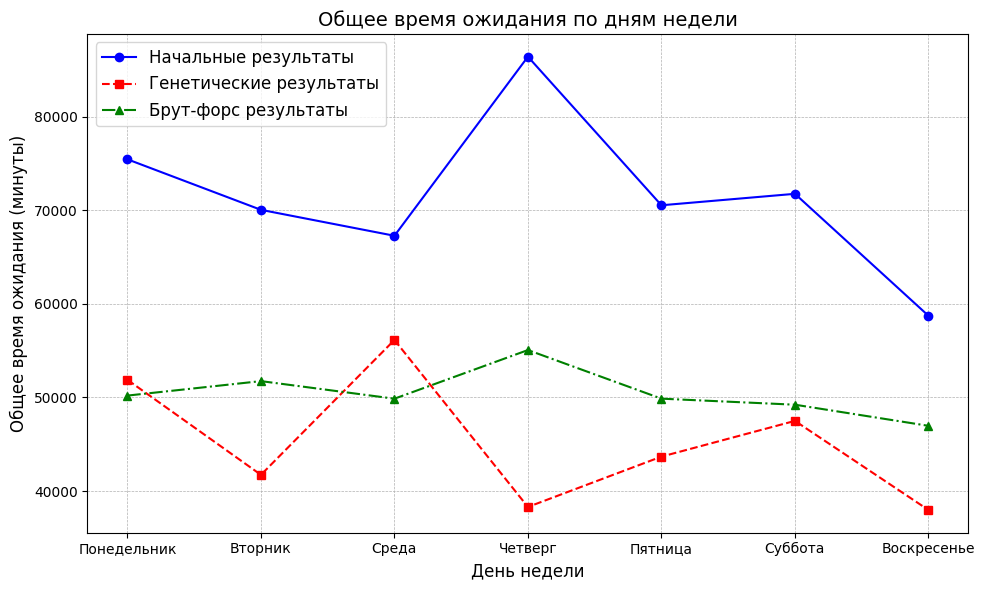

In [16]:
#cтроим графики для сравнения результатов.
def plot_total_waiting_time(wait_time_start, wait_time_genetic, wait_time_brut):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, NUM_DAYS + 1), wait_time_start, marker='o', linestyle='-', color='b', label='Начальные результаты')
    plt.plot(range(1, NUM_DAYS + 1), wait_time_genetic, marker='s', linestyle='--', color='r', label='Генетические результаты')
    plt.plot(range(1, NUM_DAYS + 1), wait_time_brut, marker='^', linestyle='-.', color='g', label='Брут-форс результаты')

    plt.title('Общее время ожидания по дням недели', fontsize=14)
    plt.xlabel('День недели', fontsize=12)
    plt.ylabel('Общее время ожидания (минуты)', fontsize=12)
    plt.xticks(range(1, NUM_DAYS + 1), ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()

#Симуляция для начального расписания
integrated_sim = IntegratedPassengerFlowSimulation(stops=sim.stops,peak_hours={"morning": PEAK_HOURS_MORNING,"evening": PEAK_HOURS_EVENING})
for day in range(NUM_DAYS):
    integrated_sim.simulate_day(day=day)

#копия для генетич. метода
sim_copy_for_genetic = Simulation()
sim_copy_for_genetic.stops = copy_schedule(sim.stops)

#делаем копию для брут-форс метода
sim_copy_for_bruteforce = Simulation()
sim_copy_for_bruteforce.stops = copy_schedule(sim.stops)

print("\n=== Изначальные результаты ===")
#тут функция принимает значения ожидания времени для всех алгоритмов и одновременно вызываются эти функции и выводятся их результаты
plot_total_waiting_time(integrated_sim.summarize_results(),genetic(sim_copy_for_genetic,population_size=5,gens=5),brute_force_optimization(sim_copy_for_bruteforce, iterations=5))